# Advanced PyMC3: What the heck is ADVI?
![PyMC3][logo]
[logo]: https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg "Logo"

Peadar Coyle - Contributor

## Why Variational inference? 
* Scaling probabilistic modelling to increasingly complex problems on increasingly large datasets. 

**PyMC3**: Variational inference: ADVI for fast approximate posterior estimation as well as mini-batch ADVI for large data sets.

**Uses** 
* Large scale topic models (LDA, Hierarchical Dirichlet Process)
* Semi-supervised classification
* Generative models of images (used in Deep Learning work)


**Limitations**
* One limitation: Variational Inference requires that intractable distributions be approximated by a class of known probability distributions. 

**Objection**
Unlike MCMC, even in the asymptotic regime we are unable to recover the true posterior distribution.
*There are solutions* 
We can use a method called **normalized flows** - this is out of the scope of this talk. There is work being done on this in PyMC3.

The normalized flows are discussed in another notebook, so you can look at it there. 

**We'll assume that these limitations don't apply to our case** 

This will offend various statisticians - and is something worth discussing. 

In [1]:

%matplotlib inline
import sys, os
sys.path.insert(0, os.path.expanduser('~/Code/Advanced_PyMC3_Talk'))

from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
import theano
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
from pymc3.variational.advi import advi, sample_vp

theano.config.compute_test_value = 'ignore'

In [2]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [3]:
blue, green, red, purple, gold, teal = sns.color_palette()



The posterior distribution is equal to the joint distribution divided by the marginal distribution of the evidence.
$$\color{red}{P(\theta\ |\ \mathcal{D})}
    = \frac{\color{blue}{P(\mathcal{D}\ |\ \theta)\ P(\theta)}}{\color{green}{P(\mathcal{D})}}
    = \frac{\color{blue}{P(\mathcal{D}, \theta)}}{\color{green}{\int P(\mathcal{D}\ |\ \theta)\ P(\theta)\ d\theta}}$$
For many useful models the marginal distribution of the evidence is hard or impossible to calculate analytically.



### Variational Inference
* Choose a class of approximating distributions
* Find the best approximation to the true posterior

Variational inference minimizes the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

$$\mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = \mathbb{E}_q\left(\log\left(\frac{\color{purple}{q(\theta)}}{\color{red}{p(\theta\ |\ \mathcal{D})}}\right)\right)$$

from approximate distributons, but we can't calculate the true posterior distribution.

Minimizing the Kullback-Leibler divergence
$$\mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = -(\underbrace{\mathbb{E}_q(\log \color{blue}{p(\mathcal{D}, \theta))} - \mathbb{E}_q(\color{purple}{\log q(\theta)})}_{\color{orange}{\textrm{ELBO}}}) + \log \color{green}{p(\mathcal{D})}$$
is equivalent to maximizing the Evidence Lower BOund (ELBO), which only requires calculating the joint distribution.

## Example of Variational Inference
In this example, we minimize the Kullback-Leibler divergence between a full-rank covariance Gaussian distribution and a diagonal covariance Gaussian distribution.

* Thanks to Austin Rochford and Taku Yoshioka for these examples


In [4]:
SIGMA_X = 1.
SIGMA_Y = np.sqrt(0.5)
CORR_COEF = 0.75

true_cov = np.array([[SIGMA_X**2, CORR_COEF * SIGMA_X * SIGMA_Y],
                     [CORR_COEF * SIGMA_X * SIGMA_Y, SIGMA_Y**2]])
true_precision = np.linalg.inv(true_cov)

approx_sigma_x, approx_sigma_y = 1. / np.sqrt(np.diag(true_precision))

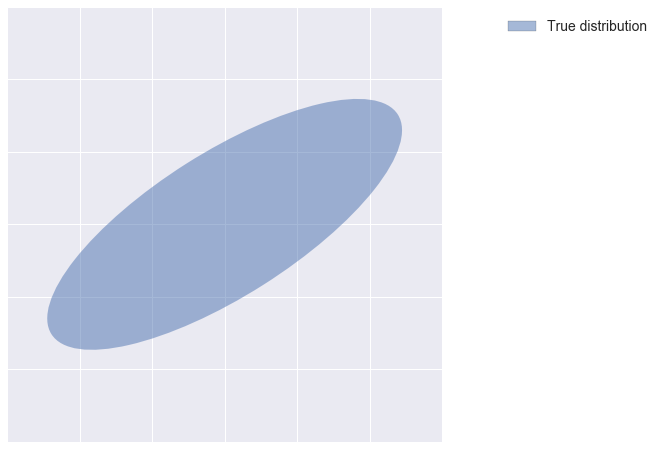

In [5]:
fig, ax  = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');


var, U = np.linalg.eig(true_cov)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.set_xlim(-3, 3);
ax.set_xticklabels([]);

ax.set_ylim(-3, 3);
ax.set_yticklabels([]);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect],
          ['True distribution'],
          bbox_to_anchor=(1.5, 1.));

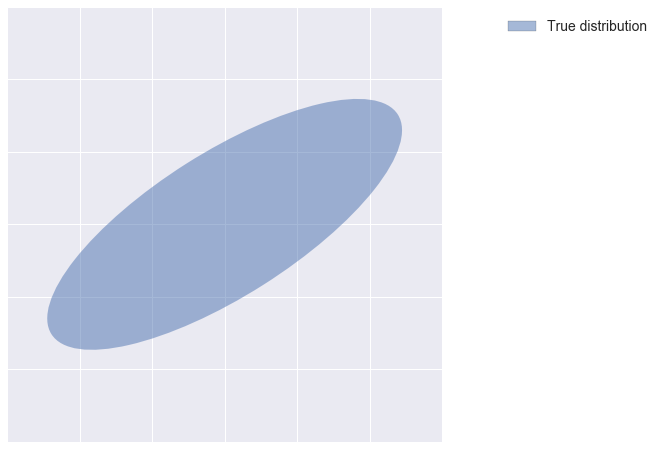

In [6]:
fig

Approximate the true distribution using a diagonal covariance Gaussian from the class
$$\mathcal{Q} = \left\{\left.N\left(\begin{pmatrix} \mu_x \\ \mu_y \end{pmatrix},
                              \begin{pmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2\end{pmatrix}\ \right|\ 
                       \mu_x, \mu_y \in \mathbb{R}^2, \sigma_x, \sigma_y > 0\right)\right\}$$

In [7]:
vi_e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991) * approx_sigma_x, 2 * np.sqrt(5.991) * approx_sigma_y)
vi_e.set_alpha(0.4)
vi_e.set_facecolor(red)
vi_e.set_zorder(11);
ax.add_artist(vi_e);

vi_rect = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.75)

ax.legend([rect, vi_rect],
          ['Posterior distribution',
           'Variational approximation'],
          bbox_to_anchor=(1.55, 1.));

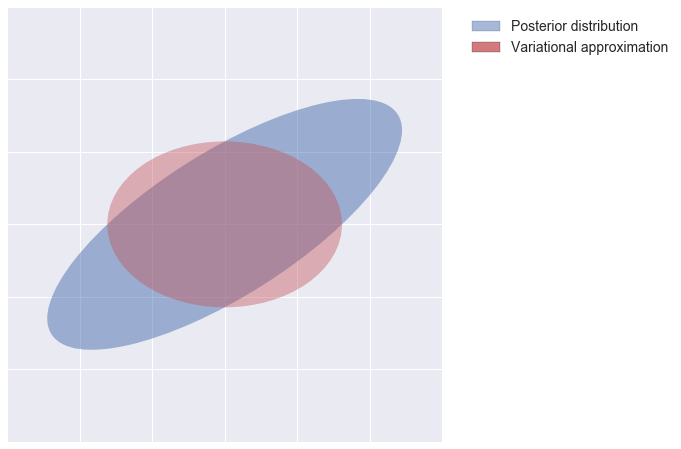

In [8]:
fig

### Pros ###
- A principled method to trade complexity for bias
- Optimization theory is applicable
- Assesment of convergence
- Scalability

### Cons###
- Biased estimate of the true posterior
- Better for prediction than interpretation
- Model-specific algorithms

### Mean field Variational Inference
Assume the variational distribution factors independently as $q(\theta_1, \ldots, \theta_n) = q(\theta_1) \cdots q(\theta_n)$

The variational approximation can be found by *coordinate ascent*
$$\begin{align*}
q(\theta_i)
    & \propto \exp\left(\mathbb{E}_{q_{-i}}(\log(\mathcal{D}, \boldsymbol{\theta}))\right) \\
q_{-i}(\boldsymbol{\theta})
    & = q(\theta_1) \cdots q(\theta_{i - 1})\ q(\theta_{i + 1}) \cdots q(\theta_n)
\end{align*}$$

#### Coordinate Ascent Cons
- Calculations are tedious, even when possible
- Convergence is slow when the number of parameters is large

### Variational Inference in Python
- Maximize ELBO using gradient ascent instead of coordinate ascent
- Tensor libraries calculate ELBO gradients automatically
- In Edward you can get BBVI
- In PyMC3 we have ADVI

#### Mathematical details

* Monte Carlo estimate of the ELBO gradient
    * For samples $\tilde{\theta}_1, \ldots, \tilde{\theta}_K \sim q(\theta)$

    $$
    \begin{align*}
    \nabla \textrm{ELBO}
        & = \mathbb{E}_q \left(\nabla\left(\log p(\mathcal{D}, \theta) - \log q(\theta)\right)\right) \\
        & \approx \frac{1}{K} \sum_{i = 1}^K \nabla\left(\log p(\mathcal{D}, \tilde{\theta}_i) - \log q(\tilde{\theta}_i)\right)
    \end{align*}
    $$

* Minibatch estimate of joint distribution
    * Sample data points $\mathbf{x}_1, \ldots, \mathbf{x}_B$ from $\mathcal{D}$

    $$\log p(\mathcal{D}, \theta) \approx \frac{N}{B} \sum_{i = 1}^B \log(\mathbf{x}_i, \theta)$$

BBVI and ADVI arise from different ways of calculating $\nabla \left(\log p(\mathcal{D}, \cdot) - \log q(\cdot)\right)$

### Automatic Differentiation Variational Inference (ADVI)

* Only applicable to differentiable probability models
* Transform constrained parameters to be unconstrained
* Approximate the posterior for unconstrained parameters with mean field Gaussian

### LDA and AEVB
Taku Yoshioka example

#### Problem
Let us consider the problem of probabilistic models with latent variables (topic models are a great example), for **Big DATA**

* One solution is autoencoding variational Bayes (AEVB; Kingma and Welling 2014).




- In AEVB, the encoder is used to infer variational parameters of approximate posterior on latent variables from given samples. By using tunable and flexible encoders such as multilayer perceptrons (MLPs), AEVB approximates complex variational posterior based on mean-field approximation, which does not utilize analytic representations of the true posterior.
- Combining AEVB with ADVI (Kucukelbir et al., 2016), we can perform posterior inference on almost arbitrary probabilistic models involving continuous latent variables.

It is worth highlighting that there's been a lot of development in the Deep Learning community on encoders. 

- In the LDA model, each document is assumed to be generated from a multinomial distribution, whose parameters are treated as latent variables. By using AEVB with an MLP as an encoder, we will fit the LDA model to the 20-newsgroups dataset.

- In this example, extracted topics by AEVB seem to be qualitatively comparable to those with a standard LDA implementation, i.e., online VB implemented on scikit-learn. Unfortunately, the predictive accuracy of unseen words is less than the standard implementation of LDA, it might be due to the mean-field approximation. 

- One solution is the work on **normalized flows** which is currently WIP for PyMC3

However, the combination of AEVB and ADVI allows us to quickly apply more complex probabilistic models than LDA to big data with the help of mini-batches. 


### Dataset
Here, we will use the 20-newsgroups dataset. This dataset can be obtained by using functions of scikit-learn. The below code is partially adopted from an example of scikit-learn (http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html). We set the number of words in the vocabulary to 2000.

In [9]:

# The number of words in the vocabulary
n_words = 2000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.960s.
Extracting tf features for LDA...
done in 2.159s.


Each document is represented by 2000-dimensional term-frequency vector. Let’s check the data.

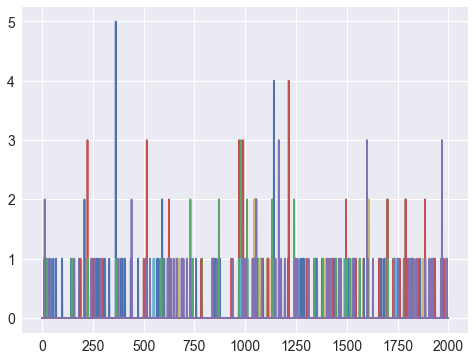

In [10]:
plt.plot(tf[:10, :].toarray().T);


### Create training set
We split the whole documents into training and test sets. The number of tokens in the training set is 610K. Sparsity of the term-frequency document matrix is 0.016%, which implies almost all components in the term-frequency matrix is zero.

In [11]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 610099
Sparsity = 0.01677095


### Log-likelihood of documents for LDA
For a document dd consisting of tokens *w*, the log-likelihood of the LDA model with *K* topics is given as
$$\begin{eqnarray}
    \log p\left(d|\theta_{d},\beta\right) & = & \sum_{w\in d}\log\left[\sum_{k=1}^{K}\exp\left(\log\theta_{d,k} + \log \beta_{k,w}\right)\right]+const,
\end{eqnarray}$$

In [12]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pm.math.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()

        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / tt.sum(vfreqs) * n_tokens

    return ll_docs_f

In the inner function, the log-likelihood is scaled for mini-batches by the number of tokens in the dataset.

With the log-likelihood function, we can construct the probabilistic model for LDA. doc_t works as a placeholder to which documents in a mini-batch are set.

For ADVI, each of random variables $θ$ and $β$, drawn from Dirichlet distributions, is transformed into unconstrained real coordinate space. To do this, by default, PyMC3 uses a centered stick-breaking transformation. Since these random variables are on a simplex, the dimension of the unconstrained coordinate space is the original dimension minus 1. For example, the dimension of $θ_d$ is the number of topics *(n_topics)* in the LDA model, thus the transformed space has dimension *(n_topics - 1)*. It shuold be noted that, in this example, we use *t_stick_breaking*, which is a numerically stable version of stick_breaking used by default. This is required to work ADVI for the LDA model.

The variational posterior on these transformed parameters is represented by a spherical Gaussian distributions *(meanfield approximation)*. Thus, the number of variational parameters of $θ_d$, the latent variable for each document, is *2 * (n_topics - 1)* for means and standard deviations.

In the last line of the below cell, *DensityDist* class is used to define the log-likelihood function of the model. The second argument is a Python function which takes observations (a document matrix in this example) and returns the log-likelihood value. This function is given as a return value of *logp_lda_doc(beta, theta)*, which has been defined above.

In [13]:
n_topics = 10
minibatch_size = 128

# Tensor for documents
doc_t = shared(np.zeros((minibatch_size, n_words)).astype('float32'), name='doc_t')

with pm.Model() as model:
    theta = Dirichlet('theta', a=(1.0 / n_topics) * np.ones((minibatch_size, n_topics)).astype('float32'),
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9))
    beta = Dirichlet('beta', a=(1.0 / n_topics) * np.ones((n_topics, n_words)).astype('float32'),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

Applied stickbreaking-transform to theta and added transformed theta_stickbreaking_ to model.
Applied stickbreaking-transform to beta and added transformed beta_stickbreaking_ to model.


In [14]:
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        # Return random data samples of a size 'minibatch_size' at each iteration
        ixs = rng.randint(data.shape[0], size=minibatch_size)
        yield [data[ixs]]

minibatches = create_minibatch(docs_tr.toarray().astype('float32'))

In [15]:
# The value of doc_t will be replaced with mini-batches
minibatch_tensors = [doc_t]

In [16]:

# observed_RVs = OrderedDict([(doc, n_samples_tr / minibatch_size)])
observed_RVs = OrderedDict([(doc, 1)])

### Encoder

Given a document, the encoder calculates variational parameters of the (transformed) latent variables, more specifically, parameters of Gaussian distributions in the unconstrained real coordinate space. 
`encode()` method is required to output variational means and stds as a tuple, as shown in the following code. As explained above, the number of variational parameters is `2 * (n_topics) - 1`. Specifically, the shape of `zs_mean`(or `zs_std`) in the method is `(minibatch_size, n_topics - 1)`. It should be noted that `zs_std` is defined as log-transformed standard deviation and this is automatically exponentiated (or bounded to be positive) in `advi_minibatch()`, the estimation function. 

To enhance generalization ability to unseen words, a Bernoulli corruption process is applied to the inputted documents. Unfortunately, I've never seen any significant improvement with this. 


In [17]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational
    means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0,random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_std = zs[:, (self.n_topics - 1):]
        return zs_mean, zs_std

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

To feed the output of the encoder to the variational parameters of $\theta$, we set an OrderedDict of tuples as below.

In [18]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, (encoder.encode(doc_t), n_samples_tr / minibatch_size))])

theta is the random variable defined in the model creation and is a key of an entry of the OrderedDict. The value (encoder.encode(doc_t), n_samples_tr / minibatch_size) is a tuple of a theano expression and a scalar. The theano expression encoder.encode(doc_t) is the output of the encoder given inputs (documents). The scalar n_samples_tr / minibatch_size specifies the scaling factor for mini-batches.

ADVI optimizes the parameters of the encoder. They are passed to the function for ADVI.

In [19]:
encoder_params = encoder.get_params()

### AEVB with ADVI
`advi_minibatch()` can be used to run AEVB with ADVI on the LDA model.

In [20]:
def run_advi():
    with model:
        v_params = pm.variational.advi_minibatch(
            n=1000, minibatch_tensors=minibatch_tensors, minibatches=minibatches,
            local_RVs=local_RVs, observed_RVs=observed_RVs, encoder_params=encoder_params,
            learning_rate=1e-2, epsilon=0.1, n_mcsamples=1
        )

    return v_params

%time v_params = run_advi()



Iteration 0 [0%]: ELBO = -5106022.06
Iteration 100 [10%]: Average ELBO = -4970940.17
Iteration 200 [20%]: Average ELBO = -4865653.49
Iteration 300 [30%]: Average ELBO = -4802046.33
Iteration 400 [40%]: Average ELBO = -4771597.28
Iteration 500 [50%]: Average ELBO = -4749812.94
Iteration 600 [60%]: Average ELBO = -4759441.7
Iteration 700 [70%]: Average ELBO = -4740283.94
Iteration 800 [80%]: Average ELBO = -4744738.79
Iteration 900 [90%]: Average ELBO = -4740387.56
Finished [100%]: ELBO = -4667604.67
CPU times: user 1min 33s, sys: 5.36 s, total: 1min 38s
Wall time: 30.4 s


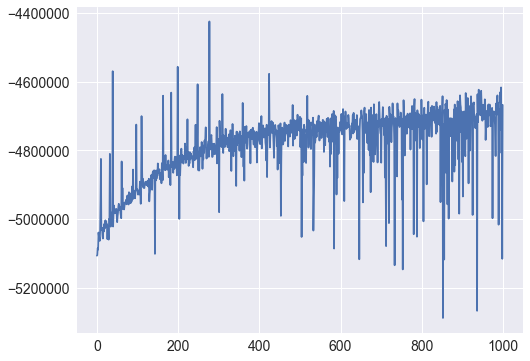

In [21]:
plt.plot(v_params.elbo_vals)

### Extraction of characteristic words of topics based on posterior samples
By using estimated variational parameters, we can draw samples from the variational posterior. To do this, we use function `sample_vp()`. Here we use this function to obtain posterior mean of the word-topic distribution β and show top-20 words frequently appeared in the 10 topics.

In [22]:
def print_top_words(beta, feature_names, n_top_words=20):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))

doc_t.set_value(docs_te.toarray().astype('float32')[:minibatch_size, :])

with model:
    samples = sample_vp(v_params, draws=100, local_RVs=local_RVs)
    beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

100%|██████████| 100/100 [00:00<00:00, 314.92it/s]

Topic #0: people like time just don think year say know use way good right years ve new said want did make
Topic #1: new know just like don 10 people use does work ve used time year years think good way right say
Topic #2: people like just think god way believe know say did make good don time want government ve years does said
Topic #3: like people know good don use does just time new need work problem used really think say ve right want
Topic #4: like use windows does just don thanks program work using want used need time know problem edu ve way window
Topic #5: use like does using want know used windows time mail work new don software available ve com just edu number
Topic #6: just think people good don does know say like time way right said things believe government god did years fact
Topic #7: like edu use new just don year used think time ve know thanks good work years mail want make team
Topic #8: don like just know does think people good make right time new use god did going way

We compare these topics to those obtained by a standard LDA implementation on scikit-learn, which is based on an online stochastic variational inference (Hoffman et al., 2013). We can see that estimated words in the topics are qualitatively similar.

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
%time lda.fit(docs_tr)
beta_sklearn = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

print_top_words(beta_sklearn, feature_names)

CPU times: user 15.1 s, sys: 150 ms, total: 15.3 s
Wall time: 14.6 s
Topic #0: president armenian mr said turkish armenians people government russian war stephanopoulos american new states year health april million 000 years
Topic #1: key law government gun use people encryption public chip state israel right rights clipper security keys used israeli guns number
Topic #2: god people jesus said believe bible did life say man christian church jews does faith religion christ christians world children
Topic #3: 10 25 db 17 11 14 16 12 15 20 24 18 13 27 19 21 34 23 cx 28
Topic #4: ax max g9v b8f a86 pl 75u 1t 145 bhj 1d9 giz 2di 3t 34u 2tm 7ey 0d 6um 0t
Topic #5: edu space com information mail available list data send 1993 file nasa research ftp email anonymous internet address pub university
Topic #6: don just like think know people time ve good way does say make want really going did things point work
Topic #7: 00 car new price 50 power good 000 used 10 bike buy sale 100 20 offer cars old

### Model evaluation
* See the documentation it's very good. [Documentation](https://pymc-devs.github.io/pymc3/notebooks/lda-advi-aevb.html)

### Variational Inference

Angelino, Elaine, Matthew James Johnson, and Ryan P. Adams. "[Patterns of Scalable Bayesian Inference](https://arxiv.org/pdf/1602.05221v2.pdf)." arXiv preprint arXiv:1602.05221 (2016).

Blei, David M., Alp Kucukelbir, and Jon D. McAuliffe. "[Variational inference: A review for statisticians](http://arxiv.org/pdf/1601.00670)." arXiv preprint arXiv:1601.00670 (2016).

Kucukelbir, Alp, et al. "[Automatic Differentiation Variational Inference](https://arxiv.org/pdf/1603.00788.pdf)." arXiv preprint arXiv:1603.00788 (2016).

Ranganath, Rajesh, Sean Gerrish, and David M. Blei. "[Black Box Variational Inference]((http://www.cs.columbia.edu/~blei/papers/RanganathGerrishBlei2014.pdf)." AISTATS. 2014.

### Models and Methods
Diederik P Kingma and Max Welling "[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)."	arXiv preprint arXiv:1312.6114 (2014).

Blei,David M. et al. "[Latent Dirichlet Allocation](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)." Journal of Machine Learning Research 3 (2003) 993-1022

Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. W. (2013). Stochastic variational inference. Journal of Machine Learning Research, 14(1), 1303-1347.